# Responding to Bias and Prejudice in Data

At best, a biased dataset is a waste of machine learning resources, and at worst it introduces bias into machine learning models. In the case of the Boston housing dataset, bias takes the form of racist and classist psuedo-measures that are pretended to affect housing prices. Removing such data prior to model training is part of ethical data engineering. 

Outliers are problematic in statistics and machine learning.  While some outliers are valid observations, others are the result of  mis-measurement, collection error, or data corruption. Valid or not, they can skew descriptive and predictive statistics. Identifying and removing or replacing them, when appropriate, is important part of data engineering for machine learning. 

###Data
In this study, I use the Boston Housing Dataset collected by the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. https://www.kaggle.com/vikrishnan/boston-house-prices 

###Problems
* Unethical data collection practices are reflected in the dataset as racial predjudice and economic class bias.
* Outliers in several dimensions affect description and prediction.

###Hypotheses
* A biased dataset affects the linear regression model and therefore introduces bias into machine learning.
* Outliers reduce the accuracy of a linear regression model.

###Objectives
* Use and compare z-score, IQR, and K-Nearest Neighbors (KNN) to identify and remove outliers.
* Create a data preparation pipeline that removes outliers and discards unethical data. 
* Create an ethical machine learning model of housing prices using Sci-kit Learn for linear regression. 

###Conclusions
* The presence of unethical data can distort a model even if the unethical data itself is found uninfluential.
* Removing outliers can reduce error and improve explanatory power in machine learning models.

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Suppress verbose outputs. DO NOT RUN during testing.
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Configure pandas to display all columns
pd.pandas.set_option('display.max_columns', None)

##Boston Housing Dataset
The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. Sci-kit learn hosts a copy and makes it available to use via import. 

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
#Load the dataset
boston = load_boston()
#Predictor and target columns are separable for machine learning.
X = boston.data
y = boston.target
#Store column names in variable
columns = boston.feature_names

In [ ]:
#Profile the dataset
print(type(boston),type(X),type(y))

<class 'sklearn.utils.Bunch'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#Concatenate X and y for Exploratory Data Analysis and data engineering.
bdf = pd.DataFrame(X)
#Reapply column names to data
bdf.columns = columns
bdf['y'] = y
print("Number of rows and columns:", bdf.shape, "\n")
bdf.head()

Number of rows and columns: (506, 14) 



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
columns

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

### Data Dictionary
1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population

### Ethical Problems
The dataset compiled in 1970 reflects the racism and classism of the era. 
* Column 12 exists because of historical racism. It could only be of interest  in a historical study of racism. It attempts to reduce home prices using the proportion of black residents in a town. 
* Column 13 exists because of historical classism, where the percentage of non-college educated and laborers pretends to reduce home prices.

The first step in the pipeline is to remove the two columns.  

In [ ]:
(bdf
 .drop(columns=['B','LSTAT'])
 .head(2)
 )

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,21.6


# Exploratory Data Analysis

### Missing Values

In [ ]:
(bdf
 .drop(columns=['B','LSTAT'])
 .isnull().any()
)

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
y          False
dtype: bool

### What is the distribution of each variable?
Descriptive statistics and boxplots profile the data.

In [ ]:
(bdf
 .drop(columns=['B','LSTAT'])
 .describe()
)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,y
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,50.000000


#### What is the average housing price in the dataset?
Price, in column y, is expressed in 1000s, with the average in 1970 at $22,530.

In [ ]:
ave_house_price = np.round(bdf['y'].mean(),2)
ave_house_price

22.53

###Are data correctly typed?
Retyping can reduce memory and calculation costs. Linear regression can be used with both continuous and categorical variables, though dummies are required for categorical data.

In [ ]:
#What are the data types?
(bdf
 .drop(columns=['B','LSTAT'])
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  y        506 non-null    float64
dtypes: float64(12)
memory usage: 47.6 KB


In [ ]:
#Are any floats mis-typed? The data dictionary suggests that CHAS and RAD
#are categorical. What is the cardinality? (How many unique values are there?)
print(bdf.CHAS.value_counts(),bdf.RAD.value_counts())

0.0    471
1.0     35
Name: CHAS, dtype: int64 24.0    132
5.0     115
4.0     110
3.0      38
6.0      26
2.0      24
8.0      24
1.0      20
7.0      17
Name: RAD, dtype: int64


In [ ]:
#Can TAX be converted to an int? How many values have decimals?
count = 0
for num in bdf.TAX:
  if num == np.floor(num): 
    count += count
    pass
  elif num == np.ceiling(num):
    count += count
count

0

In [ ]:
#Add data type corrections to the pipeline.
(bdf
 .drop(columns=['B','LSTAT'])
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    int16   
 10  PTRATIO  506 non-null    float64 
 11  y        506 non-null    float64 
dtypes: category(2), float64(9), int16(1)
memory usage: 38.2 KB


In [ ]:
sns.set_style('dark')

In [ ]:
boxplot_cols=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO','y']  

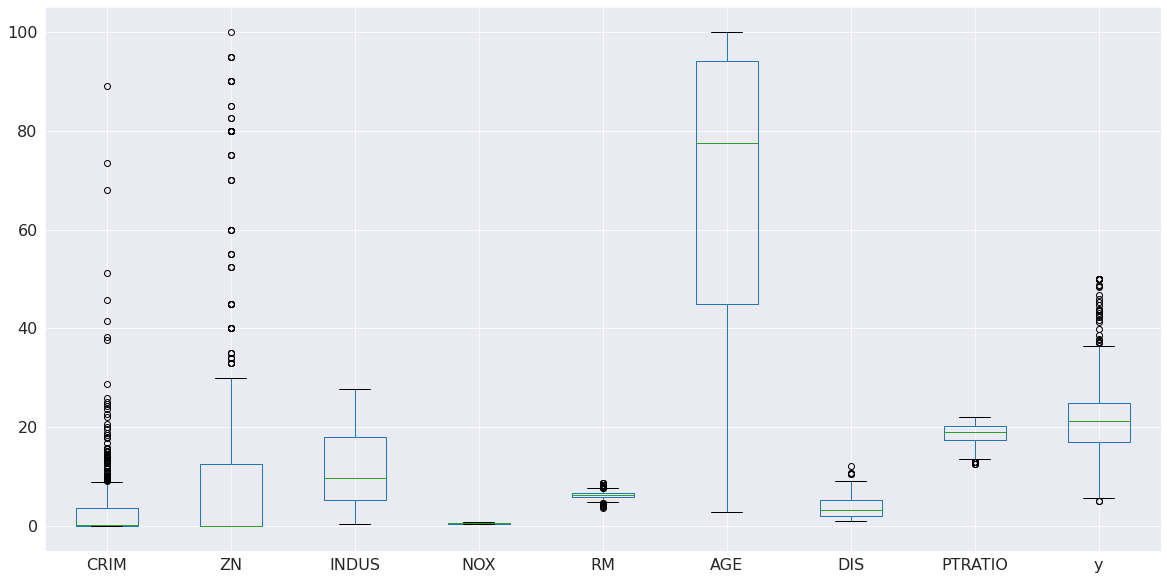

In [ ]:
(bdf
 .drop(columns=['B','LSTAT'])
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 .boxplot(column=boxplot_cols, fontsize=16, figsize=(20,10))
)

Several columns have outliers: CRIM, ZN, RM, DIS, PTRATIO and y. Many outliers are extreme.

## Removing outliers with z-score
The z-score is the number of standard deviations above or below the mean. Generally speaking, values with a z-score 3 or above are outliers and candidates for removal.

In [ ]:
#Scipy stats library offers a method for calculating the z-score
#of every value in the dataset.
from scipy import stats

In [ ]:
#Calculate the z-score and store its absolute value.
z = np.abs(stats.zscore(bdf))
#Get the datatype and shape of the result and the result itself.
print("z is shape:", z.shape,"Type:", type(z),"\n\n", z)

z is shape: (506, 14) Type: <class 'numpy.ndarray'> 

 [[0.41978194 0.28482986 1.2879095  ... 0.44105193 1.0755623  0.15968566]
 [0.41733926 0.48772236 0.59338101 ... 0.44105193 0.49243937 0.10152429]
 [0.41734159 0.48772236 0.59338101 ... 0.39642699 1.2087274  1.32424667]
 ...
 [0.41344658 0.48772236 0.11573841 ... 0.44105193 0.98304761 0.14880191]
 [0.40776407 0.48772236 0.11573841 ... 0.4032249  0.86530163 0.0579893 ]
 [0.41500016 0.48772236 0.11573841 ... 0.44105193 0.66905833 1.15724782]]


In [ ]:
#Identify the threshold. Print values in the array above threshold.
#Numpy offers a query-like method where that evaluates an expression 
#and returns two arrays: rows and columns.
threshold = 3
print(np.where(z > threshold))

(array([ 55,  56,  57, 102, 141, 142, 152, 154, 155, 160, 162, 163, 199,
       200, 201, 202, 203, 204, 208, 209, 210, 211, 212, 216, 218, 219,
       220, 221, 222, 225, 234, 236, 256, 257, 262, 269, 273, 274, 276,
       277, 282, 283, 283, 284, 347, 351, 352, 353, 353, 354, 355, 356,
       357, 358, 363, 364, 364, 365, 367, 369, 370, 372, 373, 374, 374,
       380, 398, 404, 405, 406, 410, 410, 411, 412, 412, 414, 414, 415,
       416, 418, 418, 419, 423, 424, 425, 426, 427, 427, 429, 431, 436,
       437, 438, 445, 450, 454, 455, 456, 457, 466]), array([ 1,  1,  1, 11, 12,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,
        1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  1,  5,
        5,  3,  3,  3,  3,  3,  3,  1,  3,  1,  1,  7,  7,  1,  7,  7,  7,
        3,  3,  3,  3,  3,  5,  5,  5,  3,  3,  3, 12,  5, 12,  0,  0,  0,
        0,  5,  0, 11, 11, 11, 12,  0, 12, 11, 11,  0, 11, 11, 11, 11, 11,
       11,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

Result is a tuple of two arrays, one of row numbers and a second of column numbers. For example, z[55][1] has a z-score above 3. 

In [ ]:
z[55][1]

3.375038763517309

In [ ]:
#Create a function that takes the dataframe, removes outliers using stats.zscore and 
#returns the updated dataframe. Add the function to the pipeline using pipe.
def ro_zscore(df,threshold=3):
  return df[(np.abs(stats.zscore(df))<threshold).all(axis=1)]

In [ ]:
#Add removing outliers to the pipeline before type corrections and view the shape after removal.
(bdf
 .drop(columns=['B','LSTAT'])
 .pipe(ro_zscore)
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 .shape
)

(439, 12)

In [ ]:
#Review shape of dataset prior to removal.
bdf.shape

(506, 14)

In [ ]:
#How many outliers were removed?
506-439

67

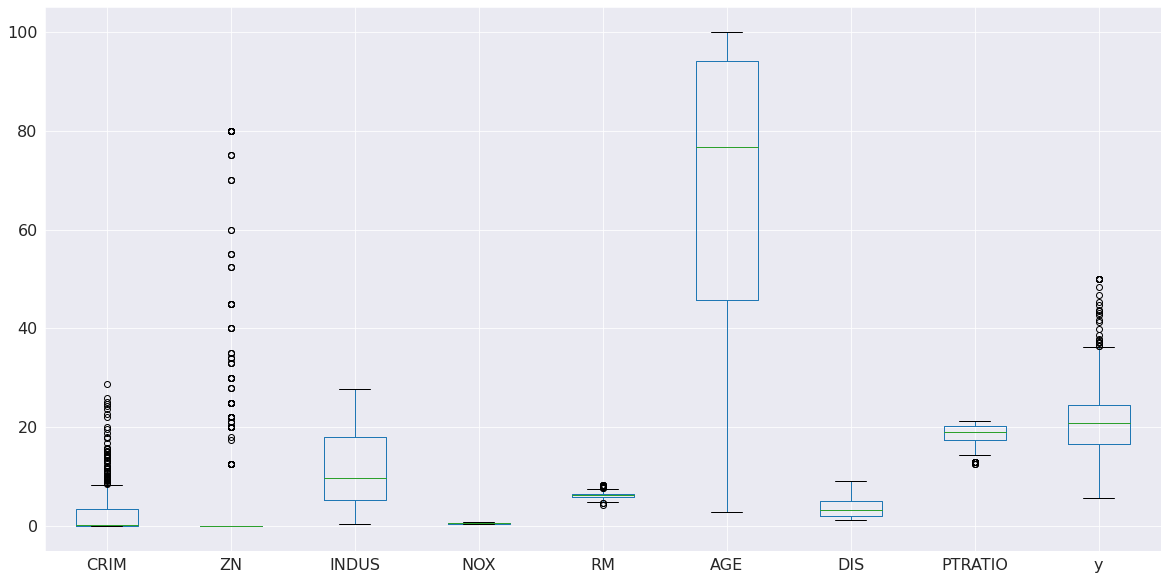

In [ ]:
#Visualize which were and were not removed.
(bdf
 .drop(columns=['B','LSTAT'])
 .pipe(ro_zscore)
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'}) 
 .boxplot(column=boxplot_cols, fontsize=16, figsize=(20,10))
)

Mixed results show CRIM was greatly improved, but the ZN distribution changed without a loss of outliers. Or, the removal of outliers changed the distribution and resulted in more different outliers. Do results differ with IQR range?

### Removing outliers with IQR Range


In [ ]:
#Use pandas df.quantile() to define Q1 and Q3 quantiles, then store IQR (Q3-Q1) in a variable.
Q1 = bdf.quantile(.25)
Q3 = bdf.quantile(.75)
IQR = Q3-Q1
print(IQR)

CRIM         3.595038
ZN          12.500000
INDUS       12.910000
CHAS         0.000000
NOX          0.175000
RM           0.738000
AGE         49.050000
DIS          3.088250
RAD         20.000000
TAX        387.000000
PTRATIO      2.800000
B           20.847500
LSTAT       10.005000
y            7.975000
dtype: float64


In [ ]:
#Define a function that removes outliers using IQR * 1.5.
#Indexing dataframes, you can input an expression, such as: df[()].
#The expression translates as "that part of itself that is ... ".  
#Returned are rows that match the criterion/a.
def ro_iqr(df):
  print("Shape of df:", df.shape)
  Q1 = df.quantile(.25)
  Q3 = df.quantile(.75)
  IQR = Q3-Q1
  #Iterate over all columns using df.columns
  for col in df.columns:
    #Exclude non-numeric columns
    if str(df[col].dtype) != 'object':
      #Build the new df:
      df = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
  print("New shape of df:", df.shape)
  return df

In [ ]:
#Add a function to remove outliers before type correction. 
(bdf
 .drop(columns=['B','LSTAT'])
 .pipe(ro_iqr)
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 #.boxplot(column=boxplot_cols, fontsize=16, figsize=(20,10))
 .head()
)

Shape of df: (506, 12)
New shape of df: (196, 12)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,y
39,0.02763,75.0,2.95,0.0,0.428,6.595,21.8,5.4011,3.0,252,18.3,30.8
40,0.03359,75.0,2.95,0.0,0.428,7.024,15.8,5.4011,3.0,252,18.3,34.9
54,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469,21.1,18.9
55,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226,17.9,35.4
56,0.02055,85.0,0.74,0.0,0.410,6.383,35.7,9.1876,2.0,313,17.3,24.7


In [ ]:
#Review shape before removing outliers
bdf.shape

(506, 11)

In [ ]:
#How many outliers were removed?
506-196

310

Shape of df: (506, 12)
New shape of df: (196, 12)


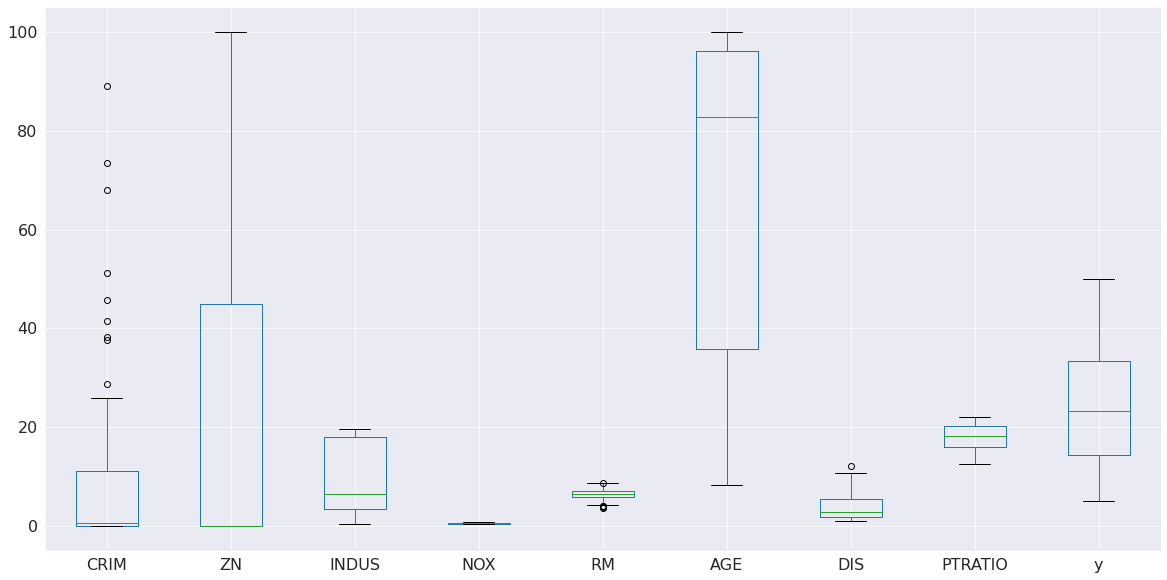

In [ ]:
(bdf
 .drop(columns=['B','LSTAT'])
 .pipe(ro_iqr)
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 .boxplot(column=boxplot_cols, fontsize=16, figsize=(20,10))
)

The approach leads to a very different outdome. ZN is more coherent, but CRIM remains problematic even with the loss of so much data. Does Sci-kit Learn's approach differ?   

### Applying functional programming to outlier removal
A core competence of data engineering is defining functions that perform common tasks and making them callable via APIs. Below is the example of z-score, though all of these methods could be part of a data engineering API.

In [ ]:
#Define a function called remove_outliers that takes the dataframe as input
#and applies a test of 3 * z-score.
def remove_outliers(df):
  print("Shape of df:",df.shape)
  #Iterate over all columns using df.columns
  for col in df.columns:
    #Exclude non-numeric columns
    if str(df[col].dtype) != 'object':
      #Build the df: df[(abs of value - column mean) < (3 * column std)] #df[()]
      df = df[np.abs(df[col]-df[col].mean()) < (3*df[col].std())]
  print("New shape of df:", df.shape)
  return df 

In [ ]:
new_df = remove_outliers(bdf)

Shape of df: (506, 14)
New shape of df: (404, 14)


# Linear Regression

####Demo 1:
For the first demonstration, the original 13 inputs and target are trained with Sci-kit Learn Linear Regression. 

The hypothesis is that Mean Absolute Error (MAE) is greater with outliers.

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
#Original dataset source
# data_source = 'https://raw.githubusercontent.com/Datasets/master/housing.csv'
# df = read_csv(data_source, header=None)
# data = df.values

In [ ]:
#After the EDA and data engineering with pandas, revert the dataframe to numpy array.
demo01 = bdf.to_numpy()

In [ ]:
# Split unengineered dataset into variables and target.
X1, y1 = demo01[:, :-1], demo01[:, -1]
print(X1.shape, y1.shape)

(506, 13) (506,)


In [ ]:
# Split dataset into into train and test sets
X01_train, X01_test, y01_train, y01_test = train_test_split(X1, y1, test_size=0.33, random_state=1)
# Print the shape of both sets
print(X01_train.shape, X01_test.shape, y01_train.shape, y01_test.shape)

(339, 13) (167, 13) (339,) (167,)


Fit, predict, and evaluate a linear regression algorithm using mean absolute error (MAE).



In [ ]:
# Instantiate the model with default parameters
model01 = LinearRegression()
# Fit the model
model01.fit(X01_train, y01_train)
# Evaluate the model
yhat01 = model01.predict(X01_test)
# Evaluate predictions
mae01 = mean_absolute_error(y01_test, yhat01)
print('MAE: %.3f' % mae01)

MAE: 3.417


In [ ]:
#What is the MAE as a percentage of the average housing price?
np.round(mae01/ave_house_price,2)

0.15

MAE is the absolute value of the difference between the predicted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average. In this case, the model achieved a MAE of 3.417, or $3,417 dollars. The error is equal to  15% of the average house price.

In [ ]:
#What were the coefficients associated with each variable?
coefs01 = pd.DataFrame()
coefs01['variables'] = bdf.columns[:-1]
coefs01['coefficients'] = model01.coef_
coefs01 = coefs01.set_index('variables')
coefs01.T

variables,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coefficients,-0.0992,0.062781,0.072581,3.010774,-20.661788,3.444966,0.00378,-1.448275,0.309305,-0.011649,-0.946003,0.0072,-0.528368


The racist and classist columns were not heavily influential variables, though their interaction can still have distorted outcomes.

* Positive coefficients indicate that as the **value** of the independent variable increases, the **mean** of the dependent variable also tends to increase. 
* Negative coefficients indicate that as the **value** of the independent variable increases, the mean of the dependent variable tends to decrease.
* Values indicate how much the mean of the dependent variable changes given a one-unit shift in the independent variable, while holding other variables in the model constant. 

In summary, this model found that housing prices are most dependent on NOX (nearby chemical contamination), which significantly decreases prices. Modest increases in price occur with proximity to the Charles River (CHAS) and the number of rooms (RM).

In [ ]:
R01 = model01.score(X1,y1)
print("R squared is: ", np.round(R01,3))

R squared is:  0.737


R-squared (R2) is the proportion of the variance in pricing that is explained by the model. A 73.7% score is below a common standard of 85-100% for explanatory power. A better score may result from a different set of independent variables.

## After Removing Outliers 

Sci-kit Learn offers a sophisticated analysis of outliers called [Local Outlier Factors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) (LOF). 

Instead of looking within a single column and applying a single evaluation (z-score or IQR), it measures the deviation of a value both within its column and with respect to its neighbors. The broader analysis is provided by the K-nearest Neighbors (KNN) algorithm. After comparing a sample to its neighbors, the sample is an outlier if it has substantially lower density than neighbors.

After training with LOF, each row in the training dataset is marked as normal (1) or an outlier (-1). Rows marked -1 will be removed from the dataset.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
# Instantiate LOF
lof = LocalOutlierFactor()
# Fit the LOF KNN algorithm of the original training dataset (X01) to identify outliers.
lof_outliers = lof.fit_predict(X01_train)
# Select all rows that are not outliers and store in a mask 
mask = lof_outliers != -1
# Use the mask to index the original training datasets and store the results in new training (X,y) datasets.
X02_train, y02_train = X01_train[mask, :], y01_train[mask]

In [ ]:
# Print the shape of the updated training dataset
print(X02_train.shape, y02_train.shape)

(305, 13) (305,)


In [ ]:
#How many rows were removed from the dataset with LOF? 
506-305
#201. Far fewer than using IQR but more than z-score. 

201

In [ ]:
# Instantiate the model
model02 = LinearRegression()
# Fit the model
model02.fit(X02_train, y02_train)
# Evaluate the model on the original X test set
y02hat = model02.predict(X01_test)
# Evaluate predictions against the original Y test set
mae02 = mean_absolute_error(y01_test, y02hat)
print('\nMAE: %.3f' % mae02)


MAE: 3.356


In [ ]:
print("Improvement in MAE after removing outliers:", np.round(mae01-mae02,3))

Improvement in MAE after removing outliers: 0.061


MAE was reduced from about **3.417** by a model fit on the entire training dataset, to about **3.356** on a model fit after outliers were removed with LOF, or $3,356 dollars.

In [ ]:
#Coeffients. Were the same coefficients. 
#What were the coefficients associated with each variable?
coefs02 = pd.DataFrame()
coefs02['variables'] = bdf.columns[:-1]
coefs02['coefficients'] = model02.coef_
coefs02 = coefs02.set_index('variables')
coefs02.T

variables,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coefficients,-0.067645,0.043027,0.059226,2.118812,-18.236214,3.779422,0.000108,-1.280321,0.286893,-0.011929,-0.993192,0.0077,-0.505648


Each model found NOX, RM, and CHAS to be the most influential variables. 

In [ ]:
#R Squared
R02 = model02.score(X1,y1)
print("R squared is: ", np.round(R02,3))
#A slight improvement in explanatory power from 73.7% to 73.8%. 

R squared is:  0.738


##Ethical Machine Learning

###Pipeline Construction

In [ ]:
#Test data preparation pipeline.
(bdf
 .drop(columns=['B','LSTAT'])
 .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
 .to_numpy()
)

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 2.9600e+02, 1.5300e+01,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        3.4700e+01],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        1.1900e+01]])

In [ ]:
#Routinize data preparation.
def prep_data(df):
  return (df
          .drop(columns=['B','LSTAT'])
          .astype({'CHAS':'category', 'RAD':'category','TAX':'int16'})
          .to_numpy()
          )

In [ ]:
#Test prep_data with dataset with boston.data dataframe (bdf)
prep_data(bdf)

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 2.9600e+02, 1.5300e+01,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        3.4700e+01],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        1.1900e+01]])

In [ ]:
test03df = prep_data(bdf)

In [ ]:
#Routinize train/test split.
def split_Xy(my_array):
  X,y = my_array[:, :-1], my_array[:, -1]
  print(X.shape, y.shape)
  return X,y

In [ ]:
#Test split_Xy function. Success.
X3,y3 = split_Xy(test03df)

(506, 11) (506,)


In [ ]:
#Routinize removing outliers with sklearn lof. Parameters are X and y.
def remove_outliers_lof(X,y):
  lof = LocalOutlierFactor()
  lof_outliers = lof.fit_predict(X)
  mask = lof_outliers != -1
  X = X[mask, :]
  y = y[mask]
  return X,y

In [ ]:
#Test removing outliers
X3o, y3o = remove_outliers_lof(X3,y3)
print(X3o.shape, y3o.shape)
#43 outliers were removed from training datasets X,y

(463, 11) (463,)


In [ ]:
#Routinize the train/test split. Returned are four sets that are assigned to calling vars.
def split_train_test(X,y):
  return train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
#Test split_train_test function. Parameters are X and y with outliers removed. Success.
X3trn, X3tst, y3trn, y3tst = split_train_test(X3o,y3o)
print(X3trn.shape, y3trn.shape, X3tst.shape, y3tst.shape)

(310, 11) (310,) (153, 11) (153,)


### Demo 3: Train/Test/Evaluate with Ethical Dataset

Successful pipeline yielded X3trn, y3trn, X3tst, and y3tst.

In [ ]:
#Instatiate
model03 = LinearRegression()

In [ ]:
#Train
model03.fit(X3trn,y3trn)

LinearRegression()

In [ ]:
#Test
yhat03 = model03.predict(X3tst)

In [ ]:
#Evaluate
mae03 = mean_absolute_error(y3tst,yhat03)
print('MAE: %.3f' % mae03)

MAE: 3.373


In [ ]:
#What were the coefficients associated with each variable?
coefs03 = pd.DataFrame()
coefs03['variables'] = bdf.drop(columns=['B','LSTAT','y']).columns
coefs03['coefficients'] = model03.coef_
coefs03 = coefs03.set_index('variables')
coefs03.T

variables,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
coefficients,-0.480605,0.055969,-0.034751,1.532658,-23.707993,5.702415,-0.041143,-1.863045,0.361397,-0.011665,-1.165953


With unethical columns removed, a model found even greater influence of other variables NOX and RM. 

In [ ]:
#R Squared
R03 = model03.score(X3trn,y3trn)
print("R Squared: ", R03)

R Squared:  0.6650606907535966


In [ ]:
#Adjusted R Squared
from sklearn.metrics import r2_score
R03_adj = r2_score(y3tst, yhat03)

In [ ]:
print("Adjuststed R Squared: ", R03_adj)

Adjuststed R Squared:  0.6327042819606521


##Conclusion


Three findings associated with training and evaluating the models:
* Removing outliers reduced Mean Absolute Error (MAE).
* While removing outliers improved R Squared, the subtraction of variables in the ethically prepared dataset decreased it. All three measures reflect only modest explanatory power.  
* The racist and classist dimensions were found uninfluential. However, the model trained on the ethically prepared dataset had more confidence in the influential variables that were present in the dataset. Coefficients associated with other independent variables grew in clarity.
  - NOX changed from -18 to -23. 
  - RM changed from 3.8 to 5.7. 

The experiment reflected in the demonstrations confirmed both hypotheses.
* The presence of unethical data can distort a model even if the unethical data itself is found uninfluential.
* Removing outliers can reduce error and improve explanatory power in machine learning models.  

Overall, both before and after ethical data preparation, the model had modest explanatory power, possibly due to the lack of better independent variables in the dataset. 